In [2]:
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import tqdm

In [6]:
def read_tmscore(path):
    with open(path, "r") as f:
        raw = f.read()
        if raw.count("\n") < 2:
            return (None, None, None)

        spl = raw.split("\n")[1].split()
        if spl[0] == "There":
            return (None, None, None)

        tm1 = float(spl[2])
        tm2 = float(spl[3])
        rmsd = float(spl[4])
        return (tm1, tm2, rmsd)


def read_scores(work_dir, alpha, delta):
    safes = glob.glob(os.path.join(work_dir, f"tmscore.a{alpha}.d{delta}", "*", "*", "safe", "*.out"))
    unsafes = glob.glob(os.path.join(work_dir, f"tmscore.a{alpha}.d{delta}", "*", "*", "unsafe", "*.out"))
    safe_tm1 = []
    safe_tm2 = []
    safe_rmsd = []
    unsafe_tm1 = []
    unsafe_tm2 = []
    unsafe_rmsd = []
    print("Reading safes")
    for safe in tqdm.tqdm(safes):
        tm1, tm2, rmsd = read_tmscore(safe)
        if tm1 == None:
            continue
        safe_tm1.append(tm1)
        safe_tm2.append(tm2)
        safe_rmsd.append(rmsd)
    print("Reading non-safes")
    for unsafe in tqdm.tqdm(unsafes):
        tm1, tm2, rmsd = read_tmscore(unsafe)
        if tm1 == None:
            continue
        unsafe_tm1.append(tm1)
        unsafe_tm2.append(tm2)
        unsafe_rmsd.append(rmsd)

    safe_df = pd.DataFrame(data={"tm1":safe_tm1, "tm2":safe_tm2, "rmsd": safe_rmsd})
    unsafe_df = pd.DataFrame(data={"tm1":unsafe_tm1, "tm2":unsafe_tm2, "rmsd": unsafe_rmsd})
    return (safe_df, unsafe_df)

In [14]:
def read_groups(path, alphas, deltas):
    groups = {}
    for alpha in alphas:
        for delta in deltas:
            groups[(alpha, delta)] = read_scores(path, alpha, delta)
    return groups

alphas = [75]
deltas = [8,10]

groups = read_groups("./../out/clusters100.20.multi-step/", alphas, deltas)

Reading safes


100%|██████████| 242039/242039 [01:23<00:00, 2913.71it/s]


Reading non-safes


100%|██████████| 43886/43886 [00:17<00:00, 2468.28it/s]


Reading safes


100%|██████████| 248308/248308 [01:56<00:00, 2129.44it/s]


Reading non-safes


100%|██████████| 55475/55475 [00:31<00:00, 1752.45it/s]


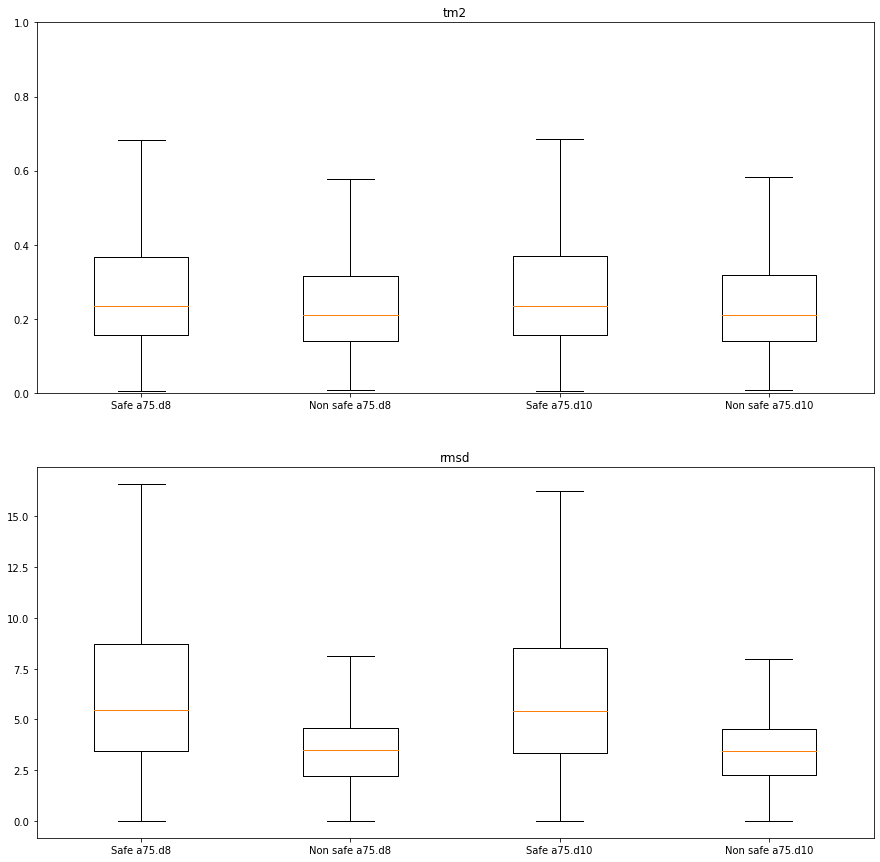

In [15]:
def boxplot(groups, alphas, deltas, features):
    fig, ax = plt.subplots(nrows=len(features), figsize=(15, 15))
    for i, f in enumerate(features):
        vals = []
        labels = []
        for a in alphas:
            for d in deltas:
                df1 = groups[(a, d)][0]
                df2 = groups[(a, d)][1]
                vals.append(df1[f].values)
                vals.append(df2[f].values)
                labels.append(f"Safe a{a}.d{d}")
                labels.append(f"Non safe a{a}.d{d}")

        ax[i].boxplot(vals, showfliers=False)
        ax[i].set_xticklabels(labels)
        ax[i].set_title(f)
        if f != "rmsd":
            ax[i].set_ylim([0,1])
        
    plt.show()

boxplot(groups, alphas, deltas, ["tm2", "rmsd"])